# Sentiment Analysis with Recurrent Neural Networks (RNN) and LSTM

#### Getting the data

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#nltk.download('all')    # run just once

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM, Dropout, Activation, Flatten, Input, SimpleRNN
from keras.callbacks import EarlyStopping

In [2]:
# import data from txt
imdb = pd.read_csv('../data/imdb_labelled.txt', sep='\t', header=None)
imdb.head()

,0,1
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [3]:
amazon = pd.read_csv('../data/amazon_cells_labelled.txt', sep='\t', header=None)
amazon.head()

,0,1
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [4]:
yelp = pd.read_csv('../data/yelp_labelled.txt', sep='\t', header=None)
yelp.head()

,0,1
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [24]:
# merge the datasets
data = pd.merge(imdb, amazon, how='outer')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1748 entries, 0 to 1747
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1748 non-null   object
 1   1       1748 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 27.4+ KB


In [25]:
data = pd.merge(data, yelp, how='outer')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2748 non-null   object
 1   1       2748 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 43.1+ KB


In [26]:
data.columns

Index([0, 1], dtype='int64')

In [27]:
# change column names 
data.columns = ['sentence', 'sentiment']
data.head()

,sentence,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [29]:
data['sentiment'].value_counts()

sentiment
1    1386
0    1362
Name: count, dtype: int64

Where '0' is the positive reviews and '1' is the negative reviews

In [30]:
data.isna().sum()

sentence     0
sentiment    0
dtype: int64

In [31]:
data.duplicated().sum()

17

In [32]:
data = data.drop_duplicates() 
data.duplicated().sum()

0

In [33]:
data.columns

Index(['sentence', 'sentiment'], dtype='object')

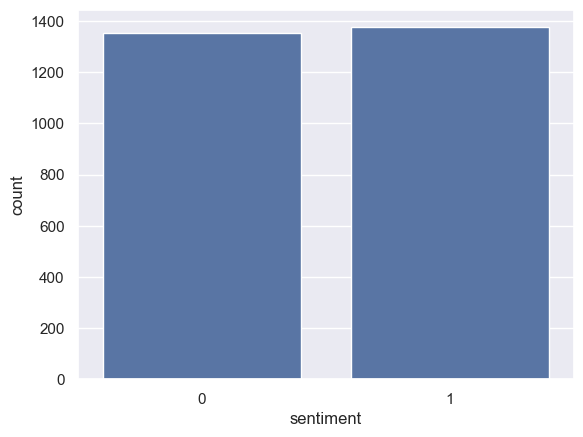

In [34]:
# grafico de barras para la columna quality
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="sentiment", data=data)

In [36]:
# Cree una función para preprocesar el texto
def preprocess_text(text):
    # Tokenice el texto utilizando la función word_tokenize()
    tokens = word_tokenize(text)

    # Pase el texto a minúscula
    tokens = [token.lower() for token in tokens]

    # Elimine las stopwords utilizando stopwords.words('english')
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lematice los tokens utilizando WordNetLemmatizer()
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Una los tokens de los procesos previos en una sola cadena
    processed_text = ' '.join(tokens)

    # Retorne el texto procesado
    return processed_text

# Aplique su función a la columna reviewText del dataframe
data['sentence'] = data['sentence'].apply(preprocess_text)

In [37]:
data.head()

,sentence,sentiment
0,", , slow-moving , aimless movie distressed , d...",0
1,"sure lost - flat character audience , nearly h...",0
2,attempting artiness black & white clever camer...,0
3,little music anything speak .,0
4,best scene movie gerardo trying find song keep...,1


In [58]:
X = data['sentence']
y = data['sentiment']

# Divida el dataframe en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [39]:
# Implement a DummyClassifier
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(X_train, y_train)
y_pred_train = dummy.predict(X_train)
y_pred_test = dummy.predict(X_test)

In [40]:
# print accuracy, precision, recall and f1-score
print("TRAIN METRICS\n")

print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("Precision:", precision_score(y_train, y_pred_train, average='macro'))
print("Recall:", recall_score(y_train, y_pred_train, average='macro'))
print("f1-score:", f1_score(y_train, y_pred_train, average='macro'))
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))


TRAIN METRICS

Accuracy: 0.5023547880690737
Precision: 0.25117739403453687
Recall: 0.5
f1-score: 0.3343782654127482
[[  0 951]
 [  0 960]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       951
           1       0.50      1.00      0.67       960

    accuracy                           0.50      1911
   macro avg       0.25      0.50      0.33      1911
weighted avg       0.25      0.50      0.34      1911



c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

In [41]:
print("TEST METRICS\n")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test, average='macro'))
print("Recall:", recall_score(y_test, y_pred_test, average='macro'))
print("f1-score:", f1_score(y_test, y_pred_test, average='macro'))
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

TEST METRICS

Accuracy: 0.5073170731707317
Precision: 0.25365853658536586
Recall: 0.5
f1-score: 0.3365695792880259
[[  0 404]
 [  0 416]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       404
           1       0.51      1.00      0.67       416

    accuracy                           0.51       820
   macro avg       0.25      0.50      0.34       820
weighted avg       0.26      0.51      0.34       820



c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

## LSTM MODEL

In [42]:
# Cree un objeto Tokenizer
max_words = 1000
max_len = 150
# updates internal vocabulary based on a list of texts
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
# transforms text to a sequence of integers
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
# pad sequences to the same length
sequences_matrix_train = pad_sequences(sequences_train, maxlen=max_len)
sequences_matrix_test = pad_sequences(sequences_test, maxlen=max_len)

In [43]:
X_train

1896                                         give 2 thumb
1096                       new battery work great phone .
2624                     've better bagel grocery store .
492              's bad 's actually worth seeing reason .
1012                    good product - incredible value .
                              ...                        
1651           love able use one headset land-line cell .
1104                 work like charm .. work advertised .
1139                                 poor sound quality .
1306    seller understanding patient , would definitel...
864     keyboard nice compromise full qwerty basic cel...
Name: sentence, Length: 1911, dtype: object

In [44]:
sequences_train

[[86, 62, 574],
 [87, 44, 17, 6, 7],
 [34, 33, 472],
 [2, 19, 2, 150, 105, 473, 575],
 [3, 35, 232, 350],
 [474, 210, 18],
 [2, 8, 4, 37, 717, 211, 233, 113, 475, 2, 718],
 [21, 576, 719, 398, 720, 261, 351],
 [],
 [139, 63, 399, 44, 44],
 [476, 234, 151, 25, 23, 113],
 [477, 121, 400, 577, 6, 18],
 [140],
 [235, 478],
 [3, 236, 10, 721, 578, 352, 172, 722, 723, 724, 262, 191],
 [121, 192, 95, 309, 27, 725, 479, 152, 114, 25],
 [64, 263, 153, 29, 237, 264],
 [27, 719, 2, 65],
 [122, 7, 154],
 [106, 23, 57, 13, 40, 123],
 [96, 16, 141],
 [480, 310, 66, 726, 481, 311, 49],
 [3, 35, 3, 727],
 [3, 26],
 [579],
 [37, 124, 20, 353, 1, 17],
 [1, 97, 728, 63, 401, 54],
 [10],
 [580, 238, 581, 5],
 [10, 1, 19, 55, 312, 351, 2, 58, 478, 81],
 [121, 6, 173, 482, 155],
 [402, 153, 21, 265, 20],
 [6, 50],
 [313, 3, 314, 3, 729],
 [10, 142, 398, 55, 151, 403, 47],
 [16, 96, 45, 730, 20, 156],
 [731, 315, 404, 732],
 [140, 4, 6, 405, 174, 2, 733, 582, 125, 734, 193, 27],
 [98, 1, 4],
 [49],
 [354, 48

In [45]:
# find best hyperparameters using grid search
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model(optimizer='rmsprop', loss='binary_crossentropy'):
    model = Sequential()
    model.add(Embedding(max_words, 32, input_length=max_len))
    model.add(LSTM(64))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

param_grid = {'batch_size': [32, 64, 128],
                'epochs': [10, 15, 20],
                'optimizer': ['adam', 'rmsprop'],
                'loss': ['binary_crossentropy', 'mse']}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(sequences_matrix_train, y_train)

# print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
54 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py", line 1491, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\USUARIO\AppData\Local\Programs\Python\P

Best: 0.780743 using {'batch_size': 128, 'epochs': 20, 'loss': 'binary_crossentropy', 'optimizer': 'rmsprop'}


In [46]:
# print metrics using best hyperparameters
model = Sequential()
model.add(Embedding(max_words, 32, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', 'Precision', 'Recall', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
model.summary()

model.fit(sequences_matrix_train, y_train, batch_size=128, epochs=20) #, validation_split=0.2)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 32)           32000     
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 56897 (222.25 KB)
Trainable params: 56897 (222.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
15/15 [==============================] - 6s 196ms/step - loss: 0.6935 - acc: 0.4882 - precision: 0.4901 - recall: 0.4656 - true_positives: 447.0000 - true_negatives: 486.0000 - false_positives: 465.0000 - false_negatives: 513.0000
Epoch 2/20
15/15 [====================

In [47]:
def kappa(score):
    tp = score[4]
    tn = score[5]
    fp = score[6]
    fn = score[7]
    k = (2*(tp*tn-fn*fp)) / ( (tp+fp) * (fp+tn) + (tp+fn) * (fn+tn) )
    return k


In [48]:
score = model.evaluate(sequences_matrix_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print('Train precision:', score[2])
print('Train recall:', score[3])
f1 = 2 * (score[2] * score[3]) / (score[2] + score[3])
print('Train f1-score:', f1)
print('Train kappa:', kappa(score))


Train loss: 0.1953485608100891
Train accuracy: 0.9277864694595337
Train precision: 0.9363057613372803
Train recall: 0.918749988079071
Train f1-score: 0.9274448030337016
Train kappa: 0.855582608009936


In [49]:
score = model.evaluate(sequences_matrix_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
f1 = 2 * (score[2] * score[3]) / (score[2] + score[3])
print('Test f1-score:', f1)
print('Test kappa:', kappa(score))

Test loss: 0.47540444135665894
Test accuracy: 0.79756098985672
Test precision: 0.8004807829856873
Test recall: 0.8004807829856873
Test f1-score: 0.8004807829856873
Test kappa: 0.5950352246763138


## RNN MODEL


In [59]:
#use grid search to find best hyperparameters for the RNN model
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model(optimizer='rmsprop', loss='binary_crossentropy'):
    model = Sequential()
    model.add(Embedding(max_words, 32, input_length=max_len))
    model.add(SimpleRNN(64))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

param_grid = {'batch_size': [32, 64, 128],
                'epochs': [10, 15, 20],
                'optimizer': ['adam', 'rmsprop'],
                'loss': ['binary_crossentropy', 'mse']}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(sequences_matrix_train, y_train)



c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
54 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py", line 1491, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\USUARIO\AppData\Local\Programs\Python\P

In [60]:
# print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.738357 using {'batch_size': 128, 'epochs': 20, 'loss': 'binary_crossentropy', 'optimizer': 'rmsprop'}


In [64]:
# print metrics using best hyperparameters
model = Sequential()
model.add(Embedding(max_words, 32, input_length=max_len))
model.add(SimpleRNN(64))
model.add(Dense(1, activation='sigmoid'))
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', 'Precision', 'Recall', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
model.summary()

model.fit(sequences_matrix_train, y_train, batch_size=128, epochs=20) #, validation_split=0.2)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 150, 32)           32000     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 64)                6208      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 38273 (149.50 KB)
Trainable params: 38273 (149.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
15/15 [==============================] - 3s 63ms/step - loss: 0.6931 - acc: 0.5264 - precision: 0.5279 - recall: 0.5427 - true_positives: 521.0000 - true_negatives: 485.0000 - false_positives: 466.0000 - false_negatives: 439.0000
Epoch 2/20
15/15 [=====================

In [65]:
#train metrics
score = model.evaluate(sequences_matrix_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print('Train precision:', score[2])
print('Train recall:', score[3])
f1 = 2 * (score[2] * score[3]) / (score[2] + score[3])
print('Train f1-score:', f1)
print('Train kappa:', kappa(score))


Train loss: 0.1475353091955185
Train accuracy: 0.9492412209510803
Train precision: 0.9371833801269531
Train recall: 0.9635416865348816
Train f1-score: 0.9501797714131418
Train kappa: 0.8984667057754466


In [66]:
#test metrics
score = model.evaluate(sequences_matrix_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
f1 = 2 * (score[2] * score[3]) / (score[2] + score[3])
print('Test f1-score:', f1)
print('Test kappa:', kappa(score))


Test loss: 0.49951648712158203
Test accuracy: 0.7865853905677795
Test precision: 0.7580299973487854
Test recall: 0.8509615659713745
Test f1-score: 0.8018120272378896
Test kappa: 0.5723005758294687
